## Utils

In [2]:
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1-koULT_rZz1E6VJJVYa-hnLXdy6XSZe2'
destination = '/content/data.zip'
download_file_from_google_drive(file_id, destination)

In [3]:
!unzip -q data.zip
!rm -rf data.zip

# Regression with RANSAC for Robust curve fitting (2 mark)

For a given polynomial, \\
$$y_{i}=\beta_{0}+\beta_{1} x_{i}+\beta_{2} x_{i}^{2}+\cdots+\beta_{m} x_{i}^{m}+\varepsilon_{i}(i=1,2, \ldots, n)$$

we can express it in a form of matrix $\mathbf{X}$, a response vector or $\vec{y}$, a parameter vector $\vec{\beta}$, and a vector $\vec{\varepsilon}$ of random errors. The model can be represented as system of linear equations, i.e.



$$\left[\begin{array}{c}y_{1} \\ y_{2} \\ y_{3} \\ \vdots \\ y_{n}\end{array}\right]=\left[\begin{array}{ccccc}1 & x_{1} & x_{1}^{2} & \ldots & x_{1}^{m} \\ 1 & x_{2} & x_{2}^{2} & \ldots & x_{2}^{m} \\ 1 & x_{3} & x_{3}^{2} & \ldots & x_{3}^{m} \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & x_{n} & x_{n}^{2} & \ldots & x_{n}^{m}\end{array}\right]\left[\begin{array}{c}\beta_{0} \\ \beta_{1} \\ \beta_{2} \\ \vdots \\ \beta_{m}\end{array}\right]+\left[\begin{array}{c}\varepsilon_{1} \\ \varepsilon_{2} \\ \varepsilon_{3} \\ \vdots \\ \varepsilon_{n}\end{array}\right]$$

$$or$$

$$\vec{y}=\mathbf{X} \vec{\beta}+\vec{\varepsilon}$$

For this system, we can calculate $\vec{\beta}$ by using the following formula,
$$
\widehat{\vec{\beta}}=\left(\mathbf{X}^{\top} \mathbf{X}\right)^{-1} \mathbf{X}^{\top} \vec{y}
$$

Using **RANSAC**, we want to avoid outliers in our curve fitting, and thus we will calculate multiple $\vec{\beta_i}$s using a set of datapoints. After calculating several $\vec{\beta_i}$ we will find the best value of ${\beta}$ using _least squares_.

In [4]:
class Regression:
    def __init__(self,order,bias=True):
        """
        Initialize regressor
        :param order: order of the polynomial
        :param bias: boolean, True for our case
        """

        self.order = order
        self.bias = bias
        self.best_beta=None
        self.beta = np.zeros(order + bias)

    def curve_fit(self,x,y,n):
        temp=[]
        for i in range(n):
          temp.append([x[i]**j for j in range(self.order+1)])
        temp=np.array(temp)
 
        y=np.array(y)

        Xt = np.transpose(temp)

        XtX = np.dot(Xt,temp)
        Xty = np.dot(Xt,y)
        self.beta = np.linalg.solve(XtX,Xty)
        
        
    def solve(self,x,y,n,iterations=10000):
        '''
        # For 1.5 marks
        Function to solve regression using RANSAC
        :param x: input
        :param y: output
        :param n: number of dataset per iteration 
        :param iterations: number of iterations to find best beta 
        '''

        self.x=x
        self.y=y
        t=0.5
        d=0
        max_error=10**18
        while iterations>0:
          all_indices = np.arange(len(x))
          np.random.shuffle(all_indices)
          maybe_indices = all_indices[:n]
          other_indices = all_indices[n:]

          maybe_points_x=np.array(x)[maybe_indices]
          maybe_points_y=np.array(y)[maybe_indices]

          other_points_x=np.array(x)[other_indices]
          other_points_y=np.array(y)[other_indices]

          other_maybe_points_x=[]
          other_maybe_points_y=[]
          self.curve_fit(list(maybe_points_x),list(maybe_points_y),n)
          for i in range(len(other_points_x)):
            a=[other_points_x[i]**j for j in range(self.order+1)]
            a1=np.transpose(np.array(a))
            c=np.dot(self.beta,a1)

            if c<t:
              other_maybe_points_x.append(other_points_x[i])
              other_maybe_points_y.append(other_points_y[i])
      
          if len(other_maybe_points_x)>=d:
            d=max(d,len(other_maybe_points_x))

            self.curve_fit(list(maybe_points_x)+list(other_maybe_points_x),list(maybe_points_y)+list(other_maybe_points_y),n+len(other_maybe_points_x))
            error=0
            temp3=list(maybe_points_x)+list(other_maybe_points_x)
            temp4=list(maybe_points_y)+list(other_maybe_points_y)
            for i in range(len(temp3)):
              v=np.dot(self.beta,np.array([temp3[i]**j for j in range(self.order+1)]))
              error+= (v-temp4[i])**2
            if error<max_error:
              self.best_beta=self.beta
              max_error=error
          
            
          iterations-=1

 
        print(self.best_beta)
        print('The best least square error is')
        blse=0
        for i in range(len(x)):
          v=np.dot(self.best_beta,np.array([x[i]**j for j in range(self.order+1)]))
          blse+= (v-y[i])**2
        print(blse)

        return self.best_beta
    
    def visualize(self,show=False):
        '''
        # For 0.5 marks
        function to visualize datapoints and optimal solution.
        '''


        x_min=min(self.x)
        x_max=max(self.x)
        x_dash=[]
        y_dash=[]
        
        while(x_min<x_max):
          x_dash.append(x_min)
          c1=0
          for i in range(self.order+1):
            c1+=self.best_beta[i]*(x_min**i)
          y_dash.append(c1)
          x_min+=0.01
        plt.scatter(self.x,self.y)
        plt.plot(x_dash,y_dash,'r')

        if show:
            plt.show()
        return None
  

## Solve and Visualize for 2nd Order (1.5 mark)

Load the dataset, solve the regression, and finally report the coeffecients, with best least square error. Also visualize it on graph.

The coeffecients of the best fit (in order of β0, β1, β2) are:
[1.27498724 2.43648501 2.58885652]
The best least square error is
158.5273715500635


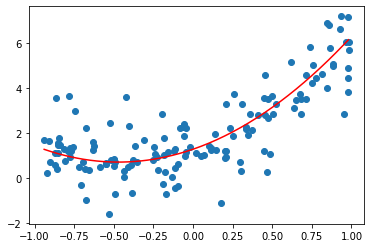

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df=pd.read_csv('2nd_order.csv')
x=list(df['x'])
y=list(df['y'])

a=Regression(2)
print('The coeffecients of the best fit (in order of β0, β1, β2) are:')
a.solve(x,y,40)
a.visualize(True)

## Solve and Visualize for 3rd Order (1.5 mark)

The coeffecients of the best fit (in order of β0, β1, β2, β3) are:
[0.52132065 1.36917419 4.12831602 4.92624513]
The best least square error is
510.72556026078445


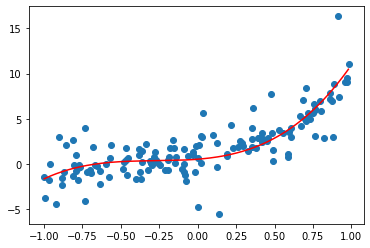

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df=pd.read_csv('3rd_order.csv')
x=list(df['x'])
y=list(df['y'])

a=Regression(3)
print('The coeffecients of the best fit (in order of β0, β1, β2, β3) are:')
a.solve(x,y,40)
a.visualize(True)

## Solve and Visualize for 4th Order (1.5 mark)

The coeffecients of the best fit (in order of β0, β1, β2, β3, β4) are:
[1.0563463  4.08597558 5.05358156 1.07308517 3.42576536]
The best least square error is
1122.8345656620827


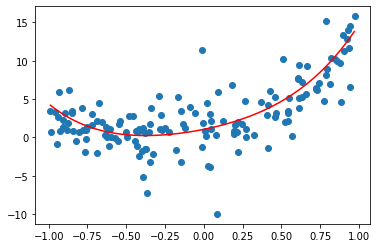

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df=pd.read_csv('4th_order.csv')
x=list(df['x'])
y=list(df['y'])

a=Regression(4)
print('The coeffecients of the best fit (in order of β0, β1, β2, β3, β4) are:')
a.solve(x,y,40)
a.visualize(True)

## Report

### What is Linear Regression? (1 mark)

Linear Regression is linear approach for modelling the relationship between one or more dependent & independent variables and a scalar response. When multiple variables are involved then it is multiple linear regression.  Linear regression is a method in which we estimate the unknown model parameters from the data. Linear regression has many practical uses like match/goal prediction, forecasting etc.

### Why RANSAC? (1 mark)

When the dataset has outliners because of the noise or other errorneous measurements, the model may give incorrect hypothesis about the interpretation of data. But when we use RANSAC, it uses repeated random sub-sampling. Hence, we can estimate the parameters of a model optimally(which fits better) even with the small amount of inliners in dataset.

### How does RANSAC help curve fitting? (1.5 marks) 
[not more than 4-5 sentences]

RANSAC algorithm uses only some points of the dataset to estimate the model parameters but it maximizes the number of inliner points. Taking only the inliner points gives us the better estimate of the interpretation of the data and hence the better curve fitting. The parameter which we can adjust in order to improve the polynomial fit is lowering the maximum distance. Thus, putting a higher tolerance on inliner points can result in improving the better curve fitting. In RANSAC, we randomly select the points and hence the chances of estimating model parameters using only the inliner points increases and this is how it helps curve fitting.